### Importing modules

In [ ]:
import torch
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader, SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from model.cnn import CNN
from tabulate import tabulate


check_gpu = torch.cuda.is_available()
device = torch.device("cpu")

if check_gpu:
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")


print(f"Using {device}")
print(f"Using {torch.get_num_threads()} threads")

Using mps
Using 4 threads


In [2]:
num_workers = 0
batch_size = 64
valid_data = 0.2

# Transforms
Transforming the images to train and test

In [ ]:
train_transforms = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(25),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

In [ ]:
train_dataset = datasets.CIFAR10(
    root="./cifar", train=True, download=True, transform=train_transforms
)
test_dataset = datasets.CIFAR10(
    root="./cifar", train=False, download=True, transform=test_transforms
)

In [5]:
classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]


In [6]:
num_train = len(train_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_data * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

In [ ]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers
)
valid_loader = DataLoader(
    train_dataset, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers
)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

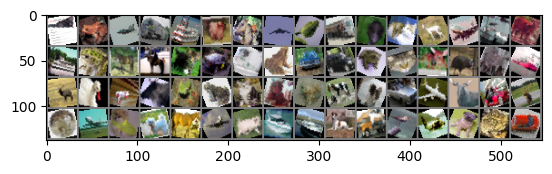

In [18]:
def imshow(img):
    img = img / 2 + 0.5
    t = np.transpose(img, (1, 2, 0))
    plt.imshow(t)


dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(utils.make_grid(images, nrow=16))

In [9]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

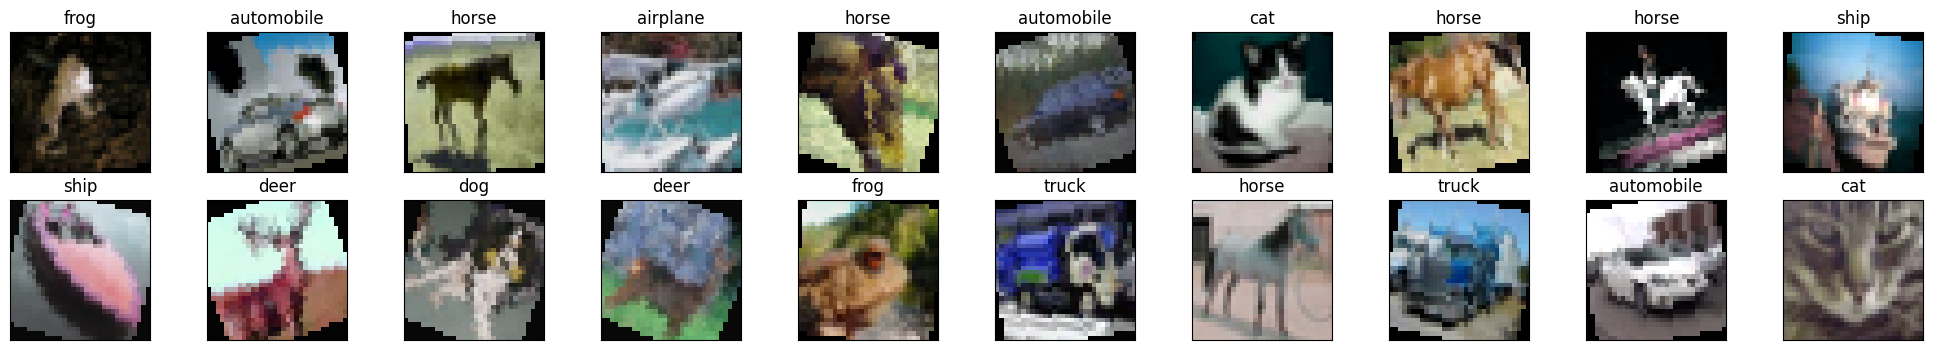

In [10]:
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, int(idx + 1), xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [12]:
model = CNN()
torch.compile(model, mode="max-autotune")
model.to(device)

print(f"Training on {device}")

Training on mps


╒════╤══════════════╤══════════════╤═════════════╤═════════════╤═════════╕
│    │   Train Loss │   Valid Loss │ Train Acc   │ Valid Acc   │ Saved   │
╞════╪══════════════╪══════════════╪═════════════╪═════════════╪═════════╡
│  1 │       1.6359 │         1.38 │ 39.87%      │ 50.28%      │ *       │
╘════╧══════════════╧══════════════╧═════════════╧═════════════╧═════════╛
╒═══╤════════╤════════╤════════╤════════╤═══╕
│ 2 │ 1.4004 │ 1.2246 │ 49.25% │ 56.09% │ * │
╘═══╧════════╧════════╧════════╧════════╧═══╛
╒═══╤════════╤════════╤════════╤════════╤═══╕
│ 3 │ 1.2959 │ 1.1591 │ 53.37% │ 58.43% │ * │
╘═══╧════════╧════════╧════════╧════════╧═══╛
╒═══╤════════╤═══════╤════════╤════════╤═══╕
│ 4 │ 1.2256 │ 1.057 │ 56.38% │ 62.81% │ * │
╘═══╧════════╧═══════╧════════╧════════╧═══╛
╒═══╤════════╤════════╤════════╤════════╤═══╕
│ 5 │ 1.1701 │ 1.0009 │ 58.66% │ 64.71% │ * │
╘═══╧════════╧════════╧════════╧════════╧═══╛
╒═══╤════════╤════════╤════════╤════════╤═══╕
│ 6 │ 1.1261 │ 0.9955 │ 60.00%

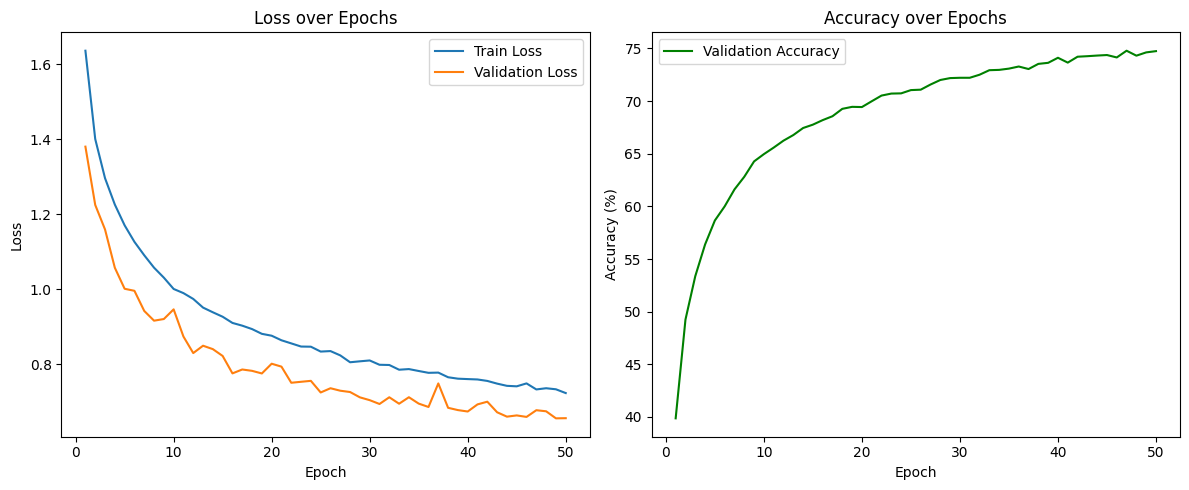

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 50
min_valid_loss = np.inf

history = []

for epoch in range(epochs):
    train_loss = 0
    valid_loss = 0
    train_correct = 0
    train_total = 0

    model.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
        _, predicted = torch.max(output.data, 1)
        train_total += target.size(0)
        train_correct += (predicted == target).sum().item()

    valid_correct = 0
    valid_total = 0
    model.eval()
    for data, target in valid_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item() * data.size(0)
        _, predicted = torch.max(output.data, 1)
        valid_total += target.size(0)
        valid_correct += (predicted == target).sum().item()

    train_loss = train_loss / len(train_sampler)
    valid_loss = valid_loss / len(valid_sampler)

    train_acc = 100 * train_correct / train_total
    valid_acc = 100 * valid_correct / valid_total

    saved = ""

    if valid_loss < min_valid_loss:
        saved = "*"
        min_valid_loss = valid_loss
        torch.save(model.state_dict(), "model.pt")

    row = [
        epoch + 1,
        f"{train_loss:.4f}",
        f"{valid_loss:.4f}",
        f"{train_acc:.2f}%",
        f"{valid_acc:.2f}%",
        saved,
    ]

    history.append(row)

    if epoch == 0:
        print(
            tabulate(
                [row],
                headers=["Train Loss", "Valid Loss", "Train Acc", "Valid Acc", "Saved"],
                tablefmt="fancy_grid",
            )
        )
    else:
        print(
            tabulate([row], tablefmt="fancy_grid", numalign="right", stralign="center")
        )

epochs_range = list(range(1, epochs + 1))
train_losses = [float(row[1]) for row in history]
valid_losses = [float(row[2]) for row in history]
valid_accuracies = [float(row[3].strip("%")) for row in history]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, valid_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, valid_accuracies, color="green", label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy over Epochs")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
test_correct = 0
test_total = 0
model.eval()

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        test_total += target.size(0)
        test_correct += (predicted == target).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f"\nFinal Accuracy on Test Set: {test_accuracy:.2f}%")


Final Accuracy on Test Set: 81.27%
